### Clustering of words based on UMAP and sbert
[sbert](https://www.sbert.net/)
[UMAP](https://umap-learn.readthedocs.io/en/latest/index.html)

In [1]:
import json
# Used to import data from S3.
import pandas as pd

# Used to create the dense document vectors.
import torch
from sentence_transformers import SentenceTransformer

# Used to create and store the Faiss index.
import faiss
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Used to do vector searches and display the results.
#from vector_engine.utils import vector_search, id2details

import os
import glob

this_file_dir = os.path.dirname(os.getcwd())

### Import
Import the file exported from the excel file

In [2]:
defFile1 = "primitiveDef.json"
defFile2 = "skillDef.json"
defFile3 = "taskDef.json"
outputName = ""

# primitive
with open(os.path.join(this_file_dir, "..", "data/in/" + str(defFile1))) as json_file:
    defWord1 = json.load(json_file)

# skill
with open(os.path.join(this_file_dir, "..", "data/in/" + str(defFile2))) as json_file:
    defWord2 = json.load(json_file)

# task
with open(os.path.join(this_file_dir, "..", "data/in/" + str(defFile3))) as json_file:
    defWord3 = json.load(json_file)

primitive = pd.read_pickle(os.path.join(this_file_dir, "..", "data/in/" + "primitive" + '.pkl'))
skill = pd.read_pickle(os.path.join(this_file_dir, "..", "data/in/" + "skill" + '.pkl'))
task = pd.read_pickle(os.path.join(this_file_dir, "..", "data/in/" + "task" + '.pkl'))

dataframe = primitive

# ALL
defWordA = defWord1 + defWord2 + defWord3
outputName = "all"

# primitive
defWordP = defWord1
##outputName = "primitive"
dataframeP = primitive

# skill
defWordS = defWord2
#outputName = "skill"
dataframeS = skill

# task
defWordT = defWord3
#outputName = "task"
dataframeT = task


# files = glob.glob(os.path.join(this_file_dir, "..", "data/out/" + outputName + "/*"))
# print(files)
# for f in files:
#     os.remove(f)

### Preprocessing
Follow guide from: https://www.pinecone.io/learn/faiss-tutorial/

In [3]:
# RUN TO REMOVE DUPLICATES
import random
# remove duplicates
defSingA = [word for word in list(set(defWordA)) if type(word) is str]
defSingP = [word for word in list(set(defWordP)) if type(word) is str]
defSingS = [word for word in list(set(defWordS)) if type(word) is str]
defSingT = [word for word in list(set(defWordT)) if type(word) is str]

i=0

indexesP = []
indexesS = []
indexesT = []

# here we create a list with the dataframes entries
for word in list(defSingP):
    i += 1
    #print("Iteration: " + str(i) + " word: " + word)
    #print(defWord.count(word))
    if defWordP.count(word) > 0:
        start_at = -1
        locs = []
        while True:
            try:
                loc = defWordP.index(word,start_at+1)
            except ValueError:
                break
            else:
                locs.append(loc)
                start_at = loc
        indexesP.append(locs)

i=0

# here we create a list with the dataframes entries
for word in list(defSingS):
    i += 1
    #print("Iteration: " + str(i) + " word: " + word)
    #print(defWord.count(word))
    if defWordS.count(word) > 0:
        start_at = -1
        locs = []
        while True:
            try:
                loc = defWordS.index(word,start_at+1)
            except ValueError:
                break
            else:
                locs.append(loc)
                start_at = loc
        indexesS.append(locs)

i=0

# here we create a list with the dataframes entries
for word in list(defSingT):
    i += 1
    #print("Iteration: " + str(i) + " word: " + word)
    #print(defWord.count(word))
    if defWordT.count(word) > 0:
        start_at = -1
        locs = []
        while True:
            try:
                loc = defWordT.index(word,start_at+1)
            except ValueError:
                break
            else:
                locs.append(loc)
                start_at = loc
        indexesT.append(locs)

#random.shuffle(defSing)

Here we extract the indexes within the ALL array for each of teh subclasses: primitives, skills and tasks

In [4]:
# Here need to create reference between word in defSingA and the words within defSingS, defSingT and deSingP. This will permit to know then which sentence-embeddings to use for the clustering

indexesAS = [] # this contains all the indexes of where the skills within defSingS are in defSingA

i = 0

# here we create a list with the dataframes entries
for word in list(defSingS):
    i += 1
    #print("Iteration: " + str(i) + " word: " + word)
    #print(defWord.count(word))
    if defSingA.count(word) > 0:
        start_at = -1
        locs = []
        while True:
            try:
                loc = defSingA.index(word,start_at+1)
            except ValueError:
                break
            else:
                locs.append(loc)
                start_at = loc
        indexesAS.extend(locs)

#print(len(indexesAS))

indexesAP = [] # this contains all the indexes of where the primitives within defSingP are in defSingA

i = 0

# here we create a list with the dataframes entries
for word in list(defSingP):
    i += 1
    #print("Iteration: " + str(i) + " word: " + word)
    #print(defWord.count(word))
    if defSingA.count(word) > 0:
        start_at = -1
        locs = []
        while True:
            try:
                loc = defSingA.index(word,start_at+1)
            except ValueError:
                break
            else:
                locs.append(loc)
                start_at = loc
        indexesAP.extend(locs)

#print(len(indexesAP))

indexesAT = [] # this contains all the indexes of where the tasks within defSingT are in defSingA

i = 0

# here we create a list with the dataframes entries
for word in list(defSingT):
    i += 1
    #print("Iteration: " + str(i) + " word: " + word)
    #print(defWord.count(word))
    if defSingA.count(word) > 0:
        start_at = -1
        locs = []
        while True:
            try:
                loc = defSingA.index(word,start_at+1)
            except ValueError:
                break
            else:
                locs.append(loc)
                start_at = loc
        indexesAT.extend(locs)

#print(len(defSingA))
#print(len(defSingT))
#print((indexesAT))

In [5]:
from sentence_transformers import SentenceTransformer

# initialize sentence transformer model
#model = SentenceTransformer('bert-base-nli-mean-tokens') #this is outdated: https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens
# info: https://www.sbert.net/docs/pretrained_models.html
model = SentenceTransformer('all-mpnet-base-v2') # SentenceTransformer('all-mpnet-base-v2')
sentence_embeddings = model.encode(defSingA)
print(sentence_embeddings.shape)

(325, 768)


### Clustering

In [6]:
n_neighbors = 10
n_components = 2

import umap
umap_embeddings = umap.UMAP(n_neighbors=n_neighbors, 
                            n_components=n_components, 
                            metric='cosine').fit_transform(sentence_embeddings)

print((umap_embeddings.shape))

(325, 2)


The embeddings have been divided in subembidding groups containing representations for tasks/skills and primitives

In [7]:
skills_embeddings = umap_embeddings[indexesAS]
primitives_embeddings = umap_embeddings[indexesAP]
tasks_embeddings = umap_embeddings[indexesAT]

In [8]:
print(skills_embeddings.shape)

(205, 2)


Now clusters are created

In [9]:
from sklearn.cluster import KMeans

clusterA = KMeans(n_clusters=3, n_init=200, random_state=0).fit(umap_embeddings)
clusterS = KMeans(n_clusters=3, n_init=200, random_state=0).fit(skills_embeddings)
clusterP = KMeans(n_clusters=3, n_init=200, random_state=0).fit(primitives_embeddings)
clusterT = KMeans(n_clusters=3, n_init=200, random_state=0).fit(tasks_embeddings)

Super-imposed plots

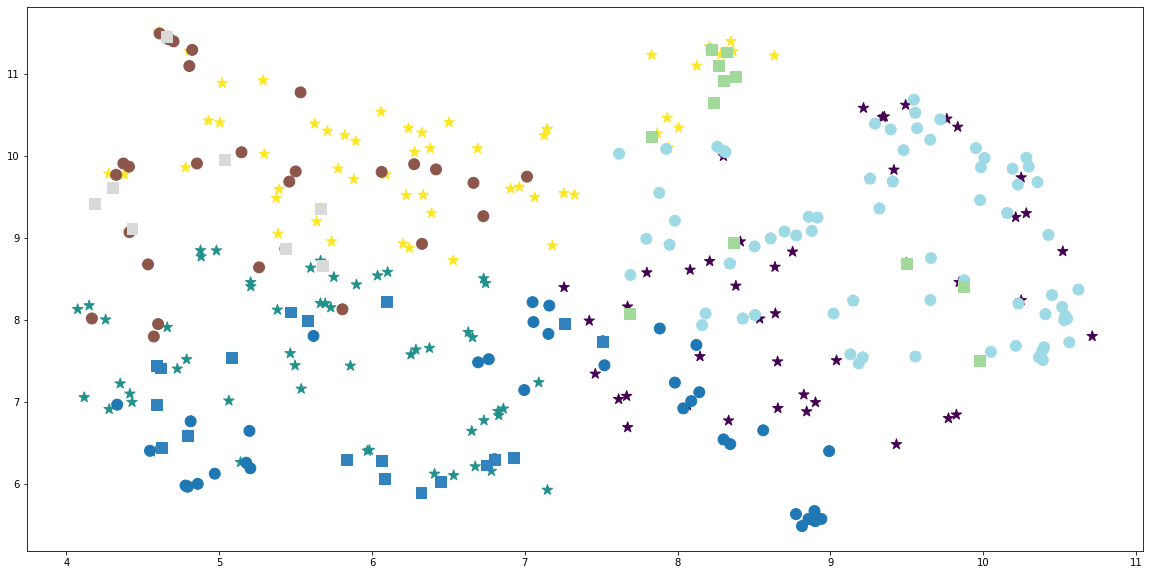

In [10]:
import matplotlib.pyplot as plt

# Prepare data for all
resultA = pd.DataFrame(umap_embeddings, columns=['x', 'y'])
resultA['labels'] = clusterA.labels_

# Prepare data for skills
resultS = pd.DataFrame(skills_embeddings, columns=['x', 'y'])
resultS['labels'] = clusterS.labels_

# Prepare data for primitives
resultP = pd.DataFrame(primitives_embeddings, columns=['x', 'y'])
resultP['labels'] = clusterP.labels_

# Prepare data for primitives
resultT = pd.DataFrame(tasks_embeddings, columns=['x', 'y'])
resultT['labels'] = clusterT.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
#plt.scatter(resultA.x, resultA.y, c=clusterA.labels_, s=30, cmap='viridis', marker="x")
plt.scatter(resultS.x, resultS.y, c=clusterS.labels_, s=120, cmap='viridis', marker="*")
plt.scatter(resultP.x, resultP.y, c=clusterP.labels_, s=120, cmap='tab20', marker="o")
plt.scatter(resultT.x, resultT.y, c=clusterT.labels_, s=120, cmap='tab20c', marker="s")

In [11]:
d = {'primitive': defSingS, 'cluster': resultS['labels'], 'x': resultS['x'], 'y': resultS['y'], 'index': indexesS}

clusterDF_S = pd.DataFrame(d)
clusterDF_S['Doc_ID'] = range(0,len(clusterDF_S))

wordsPerTopicS = clusterDF_S.groupby(['cluster'], as_index = False).agg({'primitive': ' '.join})

d = {'primitive': defSingP, 'cluster': resultP['labels'], 'x': resultP['x'], 'y': resultP['y'], 'index': indexesP}

clusterDF_P = pd.DataFrame(d)
clusterDF_P['Doc_ID'] = range(0,len(clusterDF_P))

wordsPerTopicP = clusterDF_P.groupby(['cluster'], as_index = False).agg({'primitive': ' '.join})

d = {'primitive': defSingT, 'cluster': resultT['labels'], 'x': resultT['x'], 'y': resultT['y'], 'index': indexesT}

clusterDF_T = pd.DataFrame(d)
clusterDF_T['Doc_ID'] = range(0,len(clusterDF_T))

wordsPerTopicT = clusterDF_T.groupby(['cluster'], as_index = False).agg({'primitive': ' '.join})

As suggested by this [guide](https://towardsdatascience.com/keyword-extraction-with-bert-724efca412ea) we get the most recurring keywords for each cluster

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
from nltk.corpus import wordnet as wn

# group by "X" column
groups = clusterDF_S.groupby(['cluster'])
  
labelsS = []

# extract keys from groups
keys = groups.groups.keys()

for i in keys:

    g = groups.get_group(i)
    n_gram_range = (1, 1)
    stop_words = "english"

    words = g['primitive'].to_list()

    count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit(words)
    candidates = count.get_feature_names()

    model = SentenceTransformer('all-mpnet-base-v2') # msmarco-distilbert-base-tas-b
    doc_embedding = model.encode(words)
    candidate_embeddings = model.encode(candidates)

    top_n = 2
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]

    #print("GROUP: " + str(i))
    
    #print(keywords)

    matchedKeywords = str(keywords[0] + "-" + keywords[1])
    # print(matchedKeywords)
    
    labelsS.append(matchedKeywords)

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
from nltk.corpus import wordnet as wn

# group by "X" column
groups = clusterDF_P.groupby(['cluster'])
  
labelsP = []

# extract keys from groups
keys = groups.groups.keys()

for i in keys:

    g = groups.get_group(i)
    n_gram_range = (1, 1)
    stop_words = "english"

    words = g['primitive'].to_list()

    count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit(words)
    candidates = count.get_feature_names()

    model = SentenceTransformer('all-mpnet-base-v2') # msmarco-distilbert-base-tas-b
    doc_embedding = model.encode(words)
    candidate_embeddings = model.encode(candidates)

    top_n = 2
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]

    # print("GROUP: " + str(i))
    
    # print(keywords)

    matchedKeywords = str(keywords[0] + "-" + keywords[1])
    # print(matchedKeywords)
    
    labelsP.append(matchedKeywords)

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
from nltk.corpus import wordnet as wn

# group by "X" column
groups = clusterDF_T.groupby(['cluster'])
  
labelsT = []

# extract keys from groups
keys = groups.groups.keys()

for i in keys:

    g = groups.get_group(i)
    n_gram_range = (1, 1)
    stop_words = "english"

    words = g['primitive'].to_list()

    count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit(words)
    candidates = count.get_feature_names()

    model = SentenceTransformer('all-mpnet-base-v2') # msmarco-distilbert-base-tas-b
    doc_embedding = model.encode(words)
    candidate_embeddings = model.encode(candidates)

    top_n = 2
    distances = cosine_similarity(doc_embedding, candidate_embeddings)
    keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]

    matchedKeywords = str(keywords[0] + "-" + keywords[1])
    # print(matchedKeywords)
    
    labelsT.append(matchedKeywords)

Now add keywords to each data frame

In [15]:
# By knowing the names extracted from the clusters we can then assign them to the clusterDF which can plot the scatter plot
clusterDF_S["keyword"] = ""

# We add the keyword to the cluster
for idx, row in clusterDF_S.iterrows(): 
    for i in range(0,len(labelsS)): # clusters statr from 0
        if clusterDF_S.iloc[idx]["cluster"] == (i):  
            clusterDF_S.at[idx, "keyword"] = labelsS[i]

# By knowing the names extracted from the clusters we can then assign them to the clusterDF which can plot the scatter plot
clusterDF_P["keyword"] = ""

# We add the keyword to the cluster
for idx, row in clusterDF_P.iterrows(): 
    for i in range(0,len(labelsP)): # clusters statr from 0
        if clusterDF_P.iloc[idx]["cluster"] == (i):  
            clusterDF_P.at[idx, "keyword"] = labelsP[i]

# By knowing the names extracted from the clusters we can then assign them to the clusterDF which can plot the scatter plot
clusterDF_T["keyword"] = ""

# We add the keyword to the cluster
for idx, row in clusterDF_T.iterrows(): 
    for i in range(0,len(labelsT)): # clusters statr from 0
        if clusterDF_T.iloc[idx]["cluster"] == (i):  
            clusterDF_T.at[idx, "keyword"] = labelsT[i]

In [16]:
# To stop at a precise location
#raise SystemExit("Stop right there!")

Now plot all together with names

C:\Users\z0040kve\AppData\Local\Temp/ipykernel_20952/1075462487.py:95: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


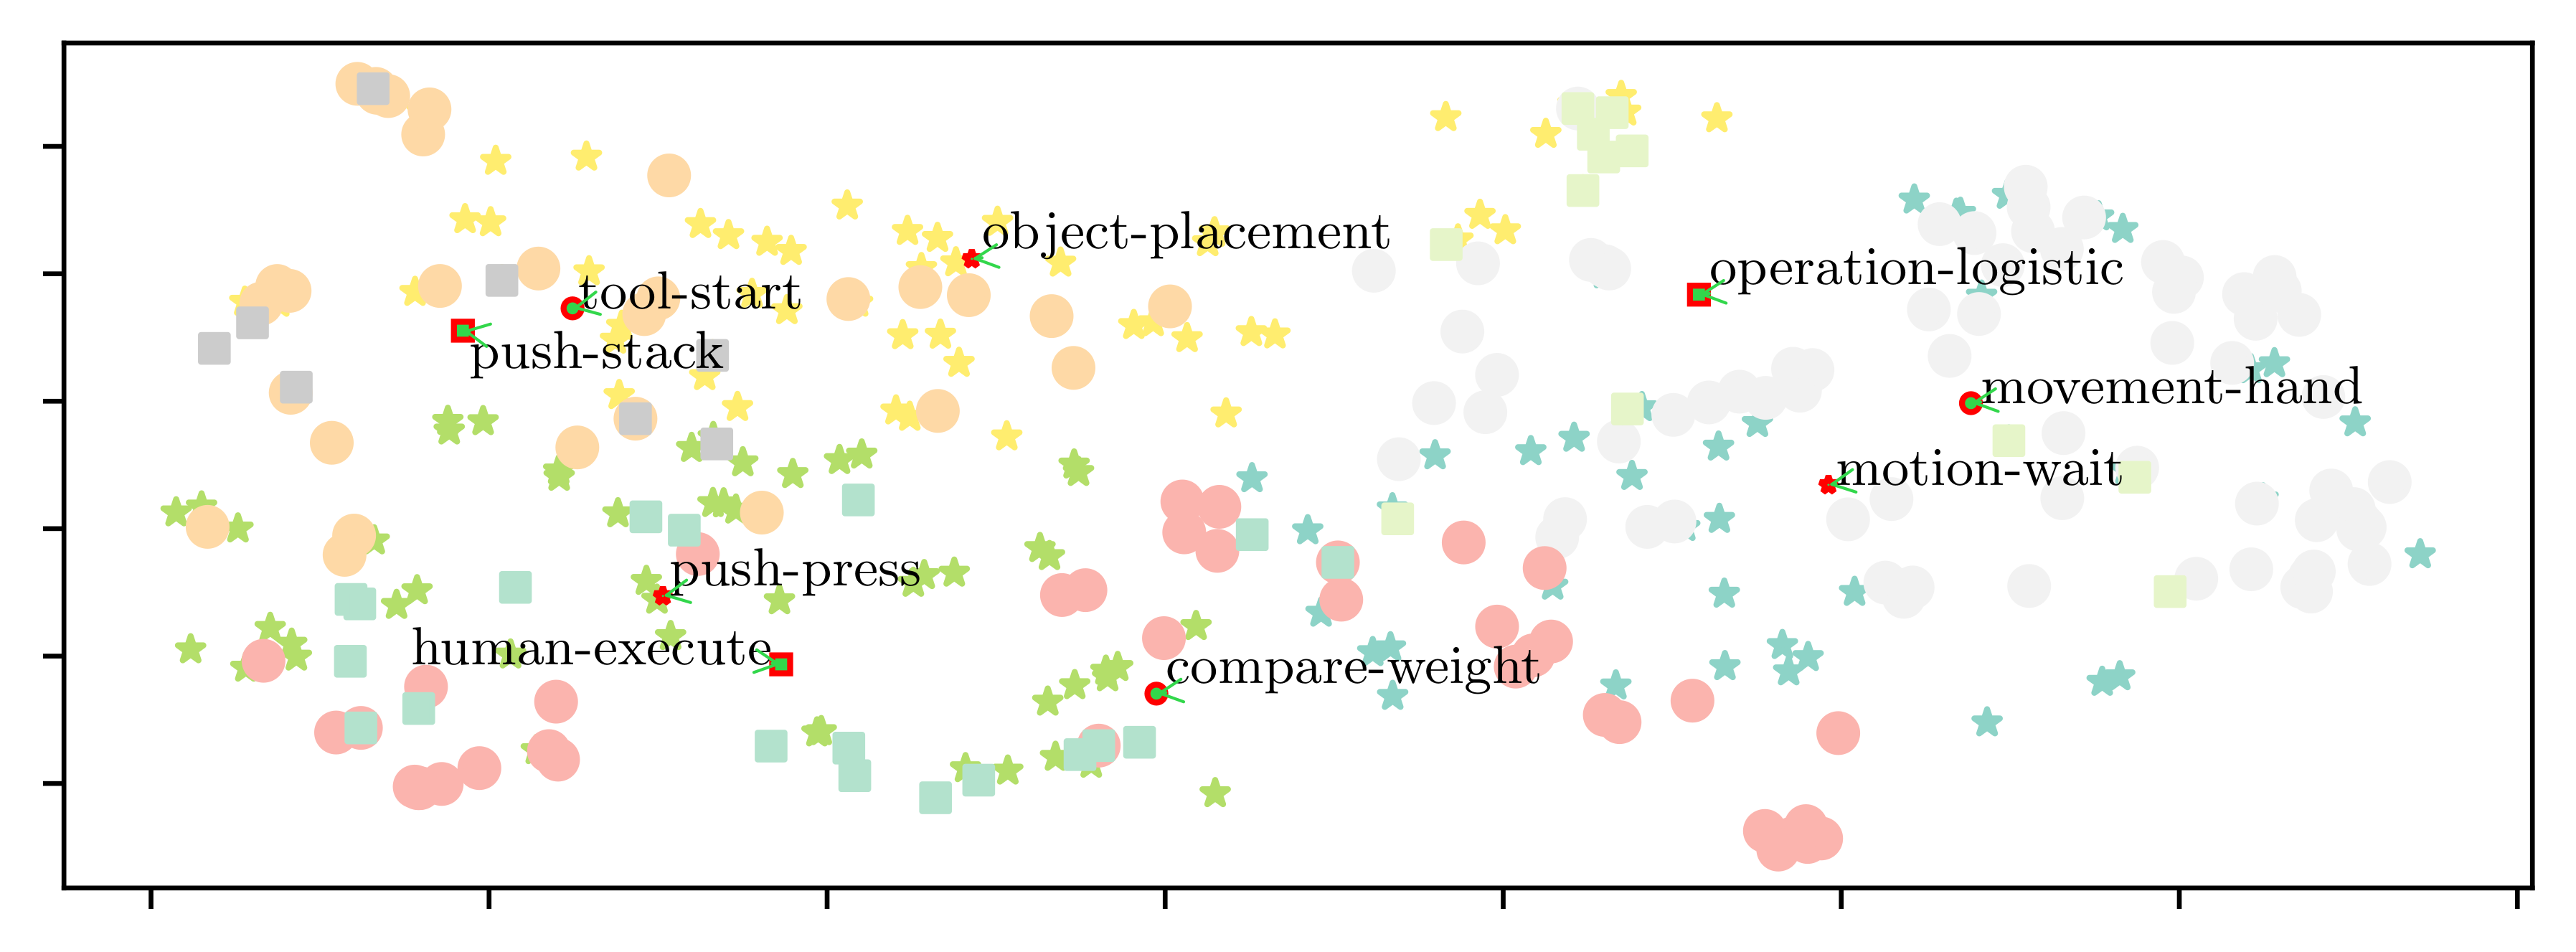

In [17]:
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from adjustText import adjust_text # to avoid overlapping text

# Latex export
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# Visualize clusters with most appearing keywords
# (20,10)
fig, ax = plt.subplots(figsize=(7.4, 2.6), dpi=600)
plt.rcParams.update({'font.size': 9.5})

#plt.scatter(outliers.x, outliers.y, color='#F2F2F2', s=30)
plt.scatter(resultS.x, resultS.y, c=clusterS.labels_, s=20, cmap='Set3', marker="*")
plt.scatter(resultP.x, resultP.y, c=clusterP.labels_, s=40, cmap='Pastel1', marker="o")
plt.scatter(resultT.x, resultT.y, c=clusterT.labels_, s=20, cmap='Pastel2', marker="s")
#plt.colorbar()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

#loop through labels and plot each cluster
texts = [] # contains all the the text entries we will show

# group by "X" column
groups = clusterDF_S.groupby('cluster')
  
# extract keys from groups
keys = groups.groups.keys()

for i in keys:

    x = groups.get_group(i)['x'].mean()
    y = groups.get_group(i)['y'].mean()

    plt.plot(x, y, marker="*", markersize=3, markeredgecolor="red", markerfacecolor="#32d74b")
    #plt.annotate(groups.get_group(i).iloc[0]["keyword"], xy = (x,y))
    texts.append(plt.text(x, y, groups.get_group(i).iloc[0]["keyword"]))

# group by "X" column
groups = clusterDF_T.groupby('cluster')
  
# extract keys from groups
keys = groups.groups.keys()

for i in keys:

    x = groups.get_group(i)['x'].mean()
    y = groups.get_group(i)['y'].mean()

    plt.plot(x, y, marker="s", markersize=3, markeredgecolor="red", markerfacecolor="#32d74b")
    #plt.annotate(groups.get_group(i).iloc[0]["keyword"], xy = (x,y))
    texts.append(plt.text(x, y, groups.get_group(i).iloc[0]["keyword"]))

# group by "X" column
groups = clusterDF_P.groupby('cluster')
  
# extract keys from groups
keys = groups.groups.keys()

for i in keys:

    x = groups.get_group(i)['x'].mean()
    y = groups.get_group(i)['y'].mean()

    plt.plot(x, y, marker="o", markersize=3, markeredgecolor="red", markerfacecolor="#32d74b")
    #plt.annotate(groups.get_group(i).iloc[0]["keyword"], xy = (x,y))
    texts.append(plt.text(x, y, groups.get_group(i).iloc[0]["keyword"]))

#plt.xticks(color='w')
#plt.yticks(color='w')

#plt.xlabel("X axis", fontsize=10)

#visualiplt.ylabel("Dimension 2", fontsize=10)

# import tikzplotlib

# tikzplotlib.save("D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/figures/knnClusteringWords.tex")
#plt.plot([6.5, 6.5], [8, 14], color='#32d74b', linestyle='--', linewidth=0.6)
#plt.plot([2, 9], [11, 11], color='#32d74b', linestyle='--', linewidth=0.6)
# adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))
adjust_text(texts, only_move={'points':'x','texts':'y','objects':'x'}, arrowprops=dict(arrowstyle="->", color='#32d74b', lw=0.5))
#plt.plot([3, 11], [10.5, 10.5], color='#8A8AFF', linestyle='--', linewidth=1)

#plt.savefig(os.path.join(this_file_dir, "..", "data/out/" + outputName + "/" + "kmeans" + str(n_neighbors) + outputName + ".png"), dpi=600, bbox_inches = 'tight')
#plt.savefig(os.path.join(this_file_dir, "..", "data/out/" + outputName + "/" + "kmeans" + str(n_neighbors) + outputName + ".pgf"), dpi=600, bbox_inches = 'tight')
plt.show()